In [297]:
# Todo: balance dataset? 

# is Embedding(max_words, 32, input_length=maxlen) correct?

# remove stopwords?
# lemmetize?

# add misc section to the explanation text?

# why embedding layer?

# use the model for a prediction as well?

# Sentiment Analysis

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from keras.callbacks import EarlyStopping
from keras.layers import SimpleRNN, LSTM, GRU, Bidirectional, Dense, Embedding
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences


### Load & explore data

In [3]:
data = pd.read_csv('emotions.csv')
data

,text,label
0,i feel so pissed off over an old friend and so...,anger
1,ive found it has made a huge difference especi...,anger
2,i also feel it is unfortunate that nearly all ...,sadness
3,i feel petty a href http clairee,anger
4,i used to believe that a feeling like fear was...,sadness
...,...,...
19995,i was i might be buying stuff from there but i...,joy
19996,i like sonam deepika and genelia who i feel ar...,joy
19997,i feel pathetic that i can hardly go a whole d...,sadness
19998,id have spent more time with her on reading i ...,sadness


In [4]:
# Find the longest row and count the number of chars/words. Useful in order to set an
# appropriate max_words for pad_sequences later on
longest_row_index = data['text'].str.len().idxmax()
longest_row = data['text'].loc[longest_row_index]

longest_row_char_count = len(longest_row)
longest_row_word_count = len(longest_row.split(' '))

print(
    f'longest row\n',
    f'characters: {longest_row_char_count}\n',
    f'words: {longest_row_word_count}'
)

longest row
 characters: 300
 words: 62


In [5]:
# Looks like we sadly don't have enough data to balance the dataset
print(data['label'].value_counts())

label
joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: count, dtype: int64


### Preprocessing

In [6]:
max_words_to_use = 1000

# Tokenize the text data (convet them into "sequences")
tokenizer = Tokenizer(num_words=max_words_to_use) # Consider only using the top 1000 words, as those 
tokenizer.fit_on_texts(data['text'])
tokenized_data = tokenizer.texts_to_sequences(data['text'])

# printing using loop for easier viewing (i fucking hate python sometimes man. Someone ought to be burned at the stake for their sins)
for i in range(5):
    print(f'seq {i}: {tokenized_data[i]}')

seq 0: [1, 2, 14, 513, 161, 115, 76, 274, 277, 3, 68, 178]
seq 1: [73, 322, 12, 99, 131, 6, 275, 29, 5, 24, 10, 3, 5, 10, 714, 119, 14, 84, 3, 152, 495]
seq 2: [1, 116, 2, 12, 21, 762, 8, 35, 5, 964, 9, 87, 4, 782, 5, 367, 57, 27, 50]
seq 3: [1, 2, 665, 6, 203, 187]
seq 4: [1, 323, 4, 300, 8, 6, 7, 13, 763, 18, 4, 27, 614, 34, 111, 162, 37, 29, 22, 11, 6, 242]


In [7]:
max_sequence_length = 100

# Pad the sequences to make them of uniform length
tokenized_padded_data = pad_sequences(tokenized_data, maxlen=max_sequence_length)
print(tokenized_padded_data[:2])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   2
   14 513 161 115  76 274 277   3  68 178]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0  73 322  12  99 131   6 275  29   5  24  10
    3   5  10 714 119  14  84   3 152 495]]


In [8]:
# One-hot encode the labels
label_binarizer = LabelBinarizer()
onehot_encoded_labels = label_binarizer.fit_transform(data['label'])
print(onehot_encoded_labels)

[[1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 1 0]
 ...
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]]


In [9]:
x_train, x_test, y_train, y_test = train_test_split(
    tokenized_padded_data,
    onehot_encoded_labels,
    test_size=0.2,
    random_state=42
)

print(
    f'x_train shape: {np.shape(x_train)}\n'
    f'y_train shape: {np.shape(y_train)}\n'
    f'x_test shape: {np.shape(x_test)}\n'
    f'y_test shape: {np.shape(y_test)}'
)

x_train shape: (16000, 100)
y_train shape: (16000, 6)
x_test shape: (4000, 100)
y_test shape: (4000, 6)


### Create & train model

In [17]:
# Manually added to array for simplicity. You can easily see the model architechtures

models = {
    'RNN':
    Sequential([
        Embedding(
            input_dim=max_words_to_use,
            input_length=max_sequence_length,
            output_dim=32 # explain
        ),
        SimpleRNN(units=32, activation='tanh'), # explain
        Dense(units=32, activation='softmax'), # needed?
        Dense(units=6, activation='softmax')
    ]),
    
    'LSTM':
    Sequential([
        Embedding(
            input_dim=max_words_to_use,
            input_length=max_sequence_length,
            output_dim=32 # explain
        ),
        LSTM(units=32, activation='tanh'), # explain
        Dense(32, activation='softmax'), # needed?
        Dense(6, activation='softmax')
    ])
}

In [18]:
histories = []

for _, model in models.items():
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Using a patience and start_from_epoch of 10 as the model is still all over the place before that 
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, start_from_epoch=10)

    # Train the model
    histories.append(model.fit(x_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping], verbose=1))

Epoch 1/100
400/400 [==============================] - 15s 32ms/step - loss: 1.6237 - accuracy: 0.3276 - val_loss: 1.5984 - val_accuracy: 0.3341
Epoch 2/100
400/400 [==============================] - 11s 27ms/step - loss: 1.5757 - accuracy: 0.3377 - val_loss: 1.5641 - val_accuracy: 0.3341
Epoch 3/100
400/400 [==============================] - 12s 31ms/step - loss: 1.4942 - accuracy: 0.3589 - val_loss: 1.3883 - val_accuracy: 0.4034
Epoch 4/100
400/400 [==============================] - 17s 42ms/step - loss: 1.4039 - accuracy: 0.4002 - val_loss: 1.3853 - val_accuracy: 0.4059
Epoch 5/100
400/400 [==============================] - 15s 38ms/step - loss: 1.2915 - accuracy: 0.4248 - val_loss: 1.2947 - val_accuracy: 0.4097
Epoch 6/100
400/400 [==============================] - 18s 46ms/step - loss: 1.2549 - accuracy: 0.4259 - val_loss: 1.2849 - val_accuracy: 0.4200
Epoch 7/100
400/400 [==============================] - 16s 41ms/step - loss: 1.2290 - accuracy: 0.4294 - val_loss: 1.2674 - val_ac

### Evaluate performance

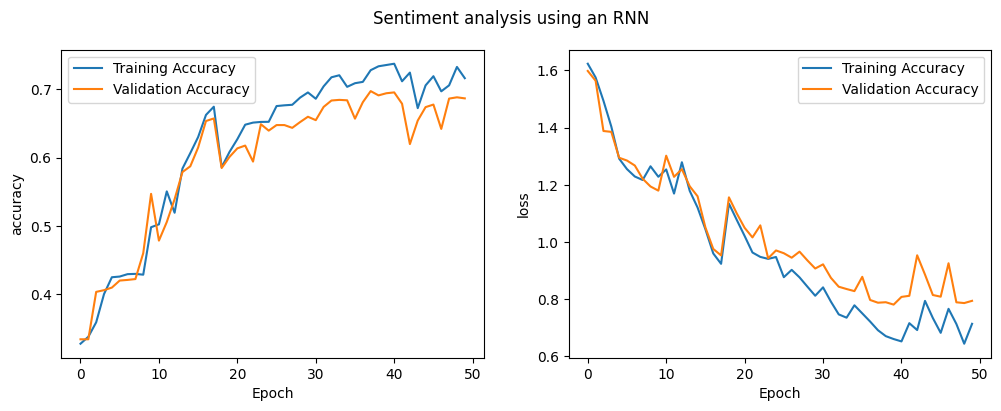

Accuracy: 69.0%
Loss: 0.75


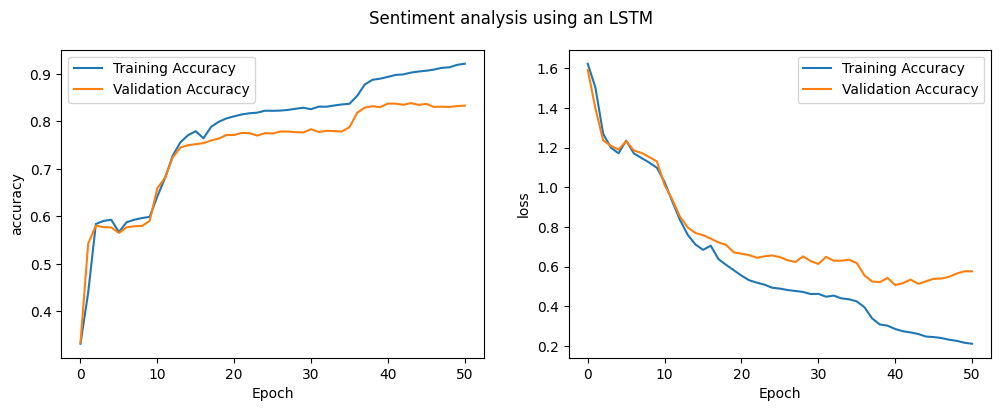

Accuracy: 84.0%
Loss: 0.46


In [19]:
for (name, model), history in zip(models.items(), histories):
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    
    plt.figure(figsize=(12, 4))
    
    for subplot, metric in enumerate(['accuracy', 'loss'], 1):
        plt.subplot(1, 2, subplot)
        plt.plot(history.history[metric], label='Training Accuracy')
        plt.plot(history.history[f'val_{metric}'], label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()

    plt.suptitle(f'Sentiment analysis using an {name}')
    plt.show()

    print(
        f'Accuracy: {round(test_accuracy, 2) * 100}%\n'
        f'Loss: {round(test_loss, 2)}'    
    )

### Hyperparameter usage motivation

- #### Motivera din modellarkitektur och val av relevanta hyperparametrar.<br>
    
    The two models used follow the recurrent neural network architecture, given the task at hand. One is a simple ("vanilla") RNN with 32 units and an activation of tanh 

    And that's really all there is to it on the architecture front. Now for the hyperparameters, which i'll be elaborating and explaning on one by one.

  - Conv2D filters
    - Trial and error (a recurring theme, as you'll see). I ran the model a few times with different filter counts in the various layers and, after doing much more research into how CNNs work, decided on 32 filters for the innitial layers and 64 for the latter. The first layers don't really need all that many filters, as they're generalizing to extremely genetic shapes such as edges, vertical lines, horizontal lines.. etc.
    The latter layers are the ones that specialize, hence the doubling of filter count.
      
  - Conv2D kernel (filter) size
    - Experimented with a few sizes and settled on the relatively standard 3x3 as it performed the best and in my opinnion overlaps enough with the surrounding pixels.
      
  - Conv2D/MaxPooling2D padding
    - Used "same" so as to not shrink the already tiny images even further. "same" will also remove the bias of having the filter only pass over the boarder pixels once as opposed to several times with the inner ones.
      
  - Conv2D/Dense activation
    - Relu on all except for the output. Relu is one of the best and most well known activation functions given its speed vs performance tradeoff, which made me decide to leave it be on all except for the output layer. The reason the output layer uses softmax is because softmax helps in generating probabilities as output for classification.
  
  - Conv2D/Dense regularization
    - After having tweaked the preceding hyperparameters to my liking i noticed the network was still overfitting to quite a gross degree. So naturally, i opted for regularization!<br>
    Started off by testing L1, L2 and L1 & L2, eventually settling on what made the most sense, L2. This helped with the issue at hand quite a bit, with the resultant model not nearly overfitting to the same extent.
  
  - MaxPooling2D pool size/stride
    - The images are already tiny, no need to downscale further than 2x, hence a stride of 2. Also left the pool size to 2x2 as that's what everyone else uses. It's a simple pooling layer, not the standard model lagrangian. No need for overcomplication.

  - Dense units
    - As before, manual trial and error. 128 nodes is what worked best for me, without absolutely grilling my shitbox school computer to high hell. That poor CPU...



- #### Vilka aktiveringsfunktioner har du använt? Varför?
  - Already stated above

- #### Vilken loss funktion har du använt? Varför?
  - I ended up using sparse_categorical_crossentropy as that was the most appropriate for a classifier. I could technically have used the standard categorical_crossentropy and just one hot encoded my labels, but that would've added unnecessary complexity. If the developers bothered to add a "sparse" version, why not use it?

- #### Har du använt någon databehandling? Varför?
  - Yes, but not a lot. I firstly needed a simple way to load the data and labels. After careful consideration, i decided that the best course of action would be to simply rename the image files to their corresponding flower names, than drag them into one single folder. This was to avoid unnecessarily complex programmatic logic, allowing me to use one simple loop for loading the data and labels.<br><br>
  I than needed to scale the images before i could efficiently feed them through the network, as they where much too big in their native form. I eventually settled scaling them down to 64x64, as that still provided an adequate amount of information (as judged by my biological photon sensor matrices) for classification.

- #### Har du använt någon regulariseringsteknik? Motivera.
  - Already stated above

- #### Hur har modellen utvärderats?
  - By looking at the validation accuracy and loss

- #### Är prestandan bra? Varför/ varför inte?
  - For a basic bitch network i slapped togeather in one afternoon? yea!<br>
  In general? No, not really.<br>Though it's worth mentioning that there are 5 labels, meaning the model's roughly 60% accuracy is actually far in advance of the 20% you'd expect from a totally random prediction. So it's clearly learnt something!

- #### Vad hade du kunnat göra för att förbättra den ytterligare?
  - There are a myriad of possible techniques which i didn't explore. Everything from simply continuing to mess around with the architecture, to performing a comprehensive gridsearch of the parameter space in order to obtain the best model. Even a few more conv and dense layers may have given the model a slight advantage. But that would've also made the train time an order of magnitude longer (trust me, i tried). All of this is to say that in this field of computer science, you can always tweak things. One must call it quits at some point!